# Exploratory Data Analysis (EDA)

This notebook performs comprehensive exploratory data analysis on the Wikipedia Pageviews dataset.

## Contents
1. Load and inspect raw data
2. Data quality checks
3. Preprocessing and cleaning
4. Descriptive statistics
5. Visualizations
6. Seasonality analysis (STL decomposition)
7. Autocorrelation analysis

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.config import load_config
from src.data_loader import load_data
from src.preprocess import preprocess_data
from src.utils import create_train_val_test_split
from src.plots import (
    plot_time_series,
    plot_train_val_test_split,
    plot_seasonality_decomposition
)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

## 1. Load Configuration and Data

In [2]:
# Load configuration
config = load_config('../configs/default.yaml')

print(f"Page: {config['data']['page_title']}")
print(f"Horizon: {config['ts_params']['horizon']} days")
print(f"Seasonal period: {config['ts_params']['seasonal_period']} days")
print(f"Random seed: {config['random_seed']}")

Page: Bitcoin
Horizon: 30 days
Seasonal period: 7 days
Random seed: 42


In [3]:
# Load raw data from Wikipedia API
raw_df = load_data(
    page_title=config['data']['page_title'],
    start_date=config['data']['start_date'],
    end_date=config['data']['end_date'],
    cache_dir='../data'
)

print(f"\nRaw data shape: {raw_df.shape}")
print(f"Date range: {raw_df['ds'].min()} to {raw_df['ds'].max()}")
print(f"Total days: {(raw_df['ds'].max() - raw_df['ds'].min()).days}")

[OK] Loaded data from cache: ..\data\Bitcoin_2020-01-01_2024-12-31.json

Raw data shape: (1827, 2)
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
Total days: 1826


## 2. Data Quality Checks

In [4]:
# Check for missing values
print("Missing values:")
print(raw_df.isnull().sum())
print(f"\nMissing percentage: {raw_df['y'].isnull().sum() / len(raw_df) * 100:.2f}%")

Missing values:
ds    0
y     0
dtype: int64

Missing percentage: 0.00%


In [5]:
# Basic statistics
print("\nDescriptive Statistics:")
print(raw_df['y'].describe())


Descriptive Statistics:
count     1827.000000
mean      9460.661741
std       6728.151616
min       2903.000000
25%       5351.500000
50%       6721.000000
75%      11297.500000
max      63121.000000
Name: y, dtype: float64


In [6]:
# Check for duplicates
duplicates = raw_df['ds'].duplicated().sum()
print(f"\nDuplicate dates: {duplicates}")


Duplicate dates: 0


## 3. Visualize Raw Data

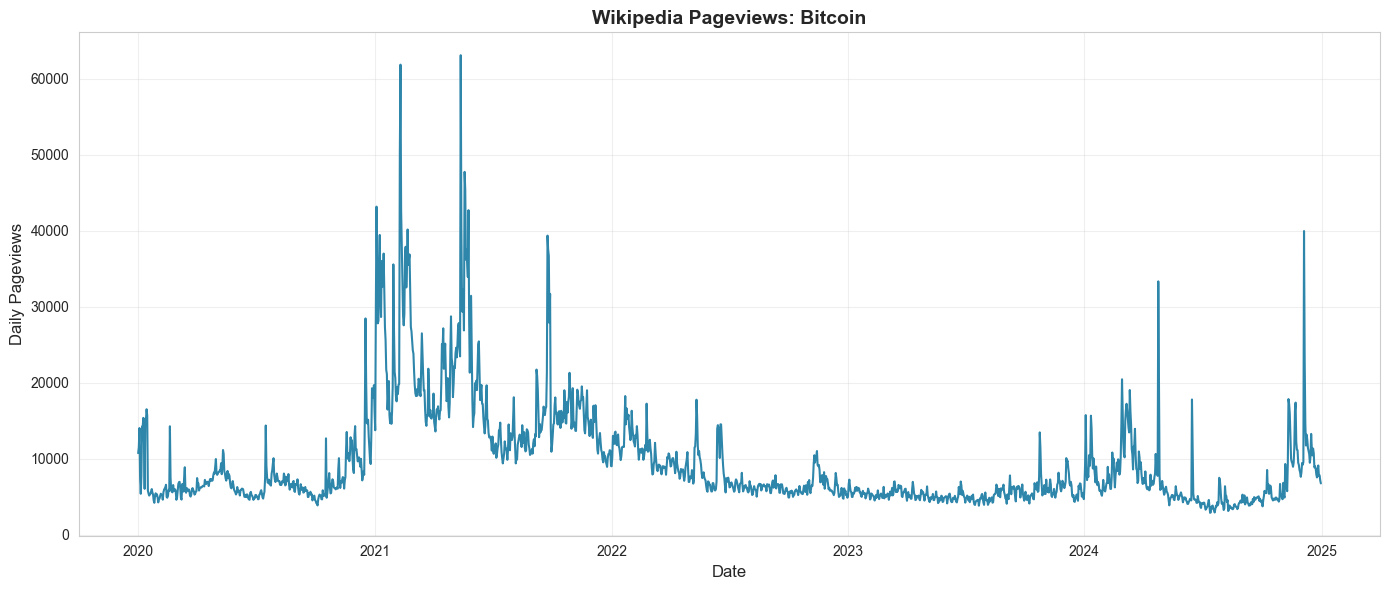

In [7]:
# Plot full time series
plot_time_series(
    raw_df,
    title=f"Wikipedia Pageviews: {config.page_title}",
    ylabel="Daily Pageviews"
)

## 4. Data Preprocessing

In [8]:
# Preprocess data
clean_df, preprocessor = preprocess_data(raw_df, config, fit=True)

print(f"\nClean data shape: {clean_df.shape}")
print(f"Records removed: {len(raw_df) - len(clean_df)}")


=== Preprocessing Training Data ===
[OK] Validated consistent daily frequency
[OK] No missing values found
[OK] Outlier bounds (winsorization): [3563.3, 36912.0]
[OK] Handled 38 outliers (2.08%) using winsorization

[OK] Preprocessing complete: 1827 records

Clean data shape: (1827, 2)
Records removed: 0


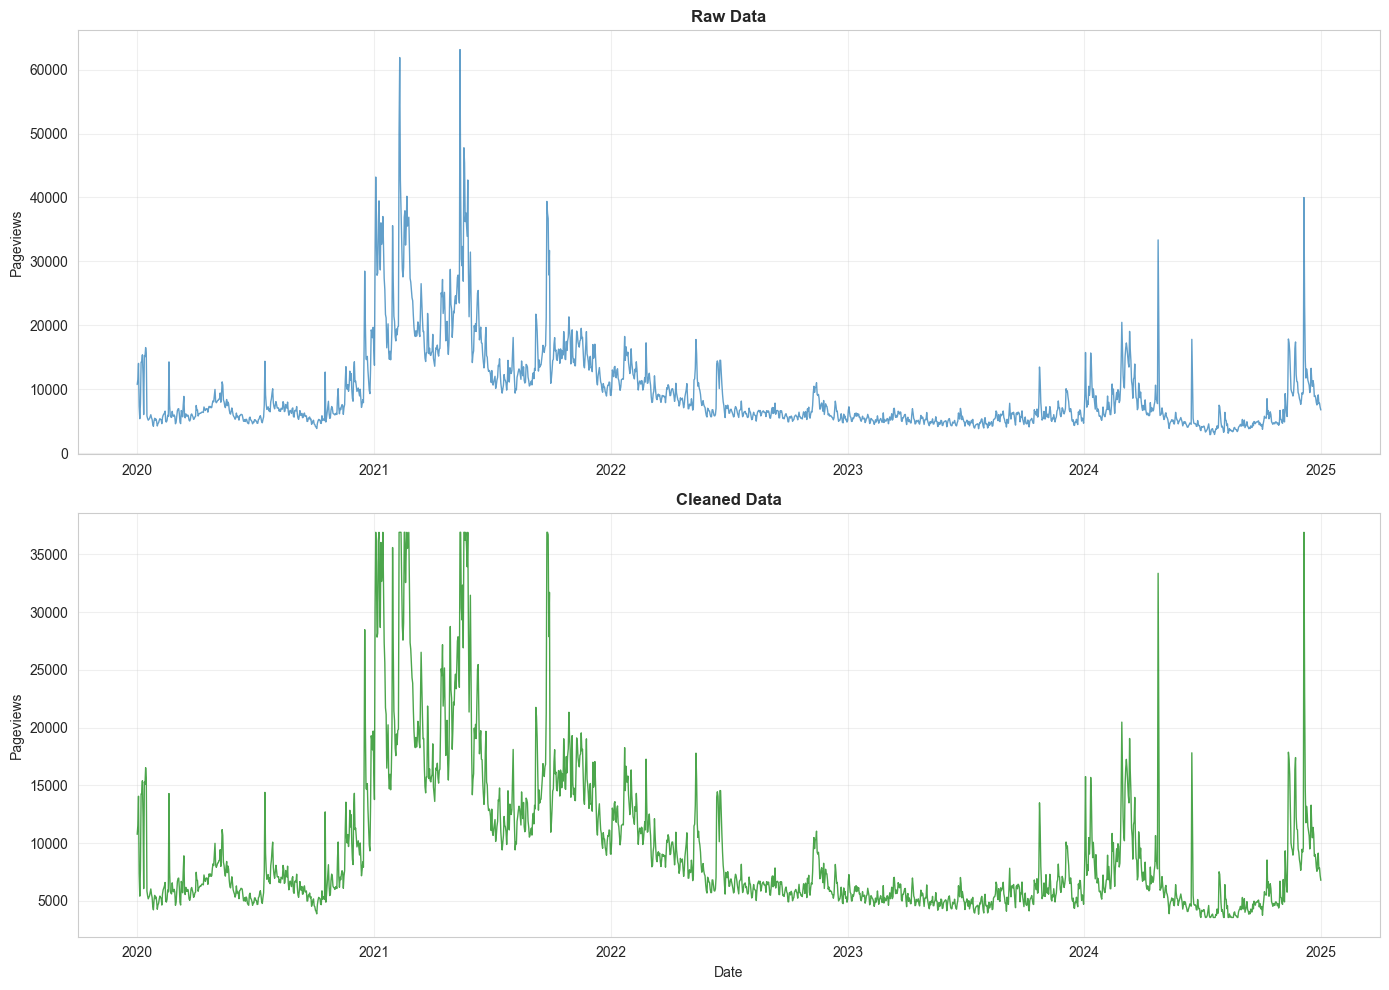

In [9]:
# Compare raw vs cleaned
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(raw_df['ds'], raw_df['y'], linewidth=1, alpha=0.7)
axes[0].set_title('Raw Data', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Pageviews')
axes[0].grid(True, alpha=0.3)

axes[1].plot(clean_df['ds'], clean_df['y'], linewidth=1, alpha=0.7, color='green')
axes[1].set_title('Cleaned Data', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pageviews')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Distribution Analysis

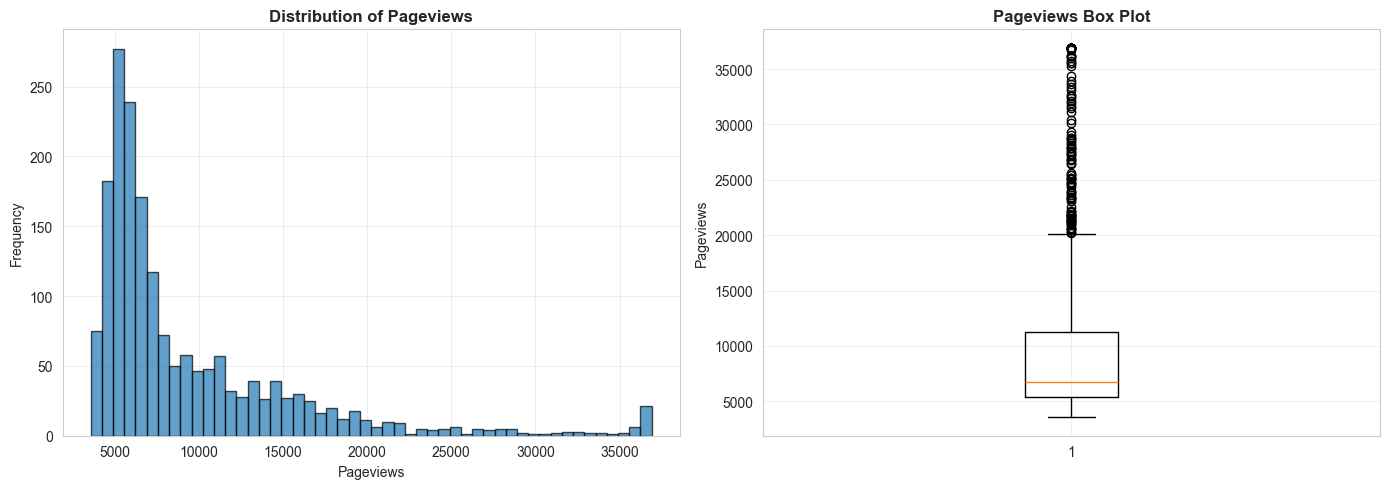

In [10]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(clean_df['y'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Pageviews', fontweight='bold')
axes[0].set_xlabel('Pageviews')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(clean_df['y'])
axes[1].set_title('Pageviews Box Plot', fontweight='bold')
axes[1].set_ylabel('Pageviews')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Seasonality Analysis

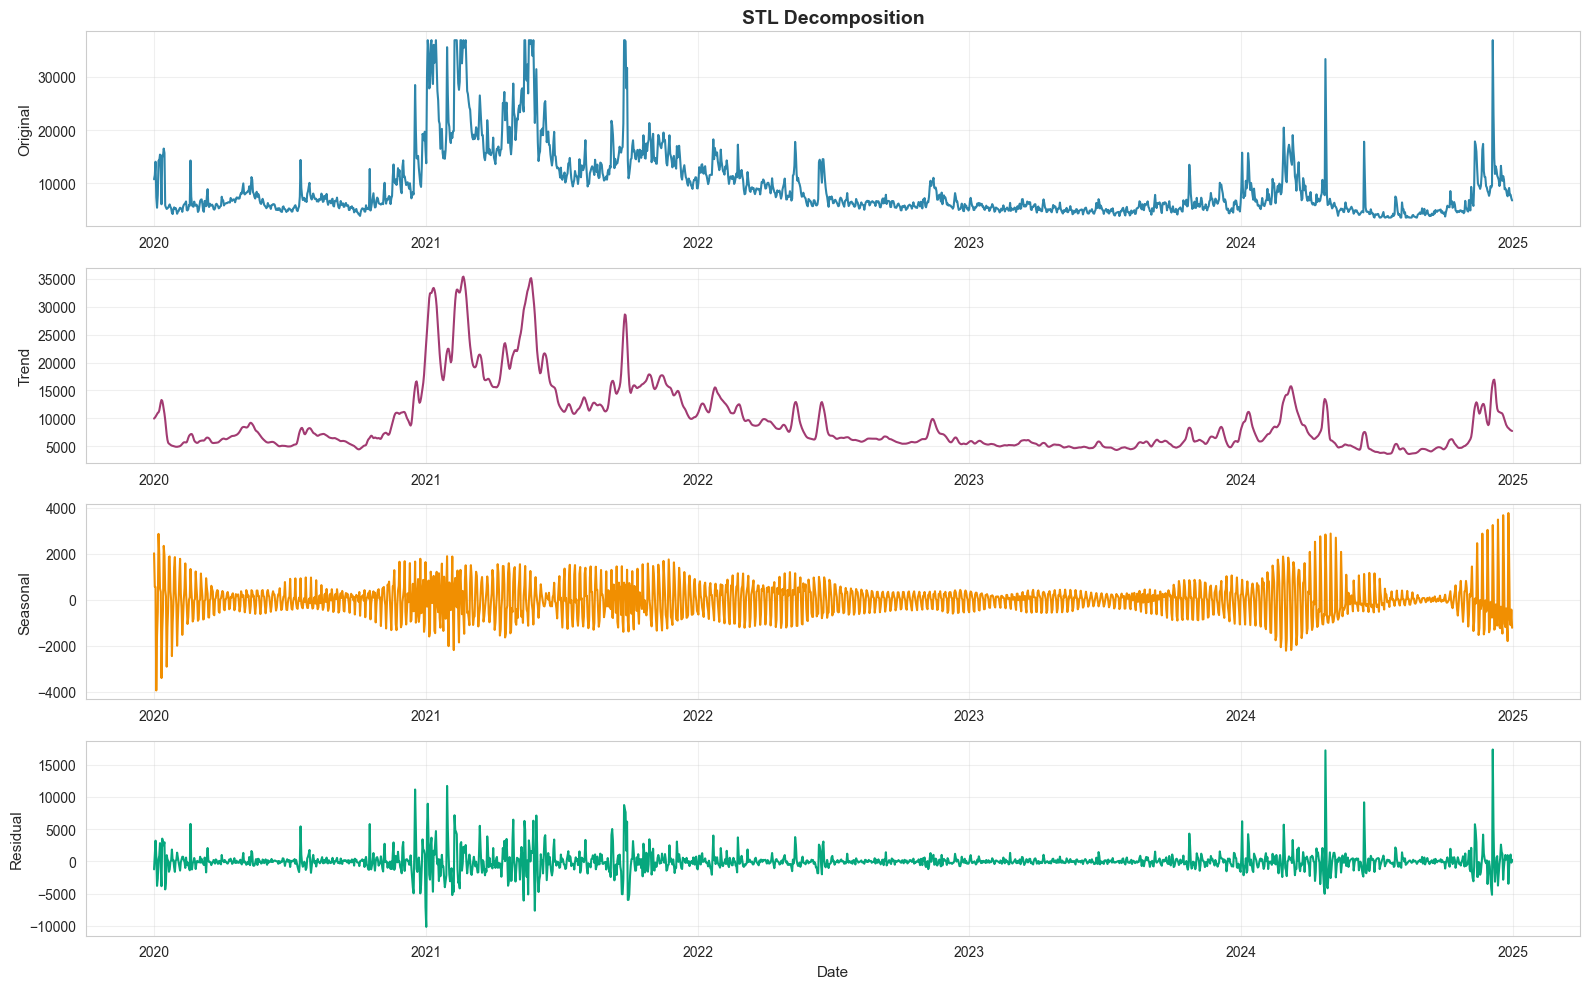

In [11]:
# STL Decomposition
plot_seasonality_decomposition(
    clean_df,
    period=config['ts_params']['seasonal_period']
)

## 7. Autocorrelation Analysis

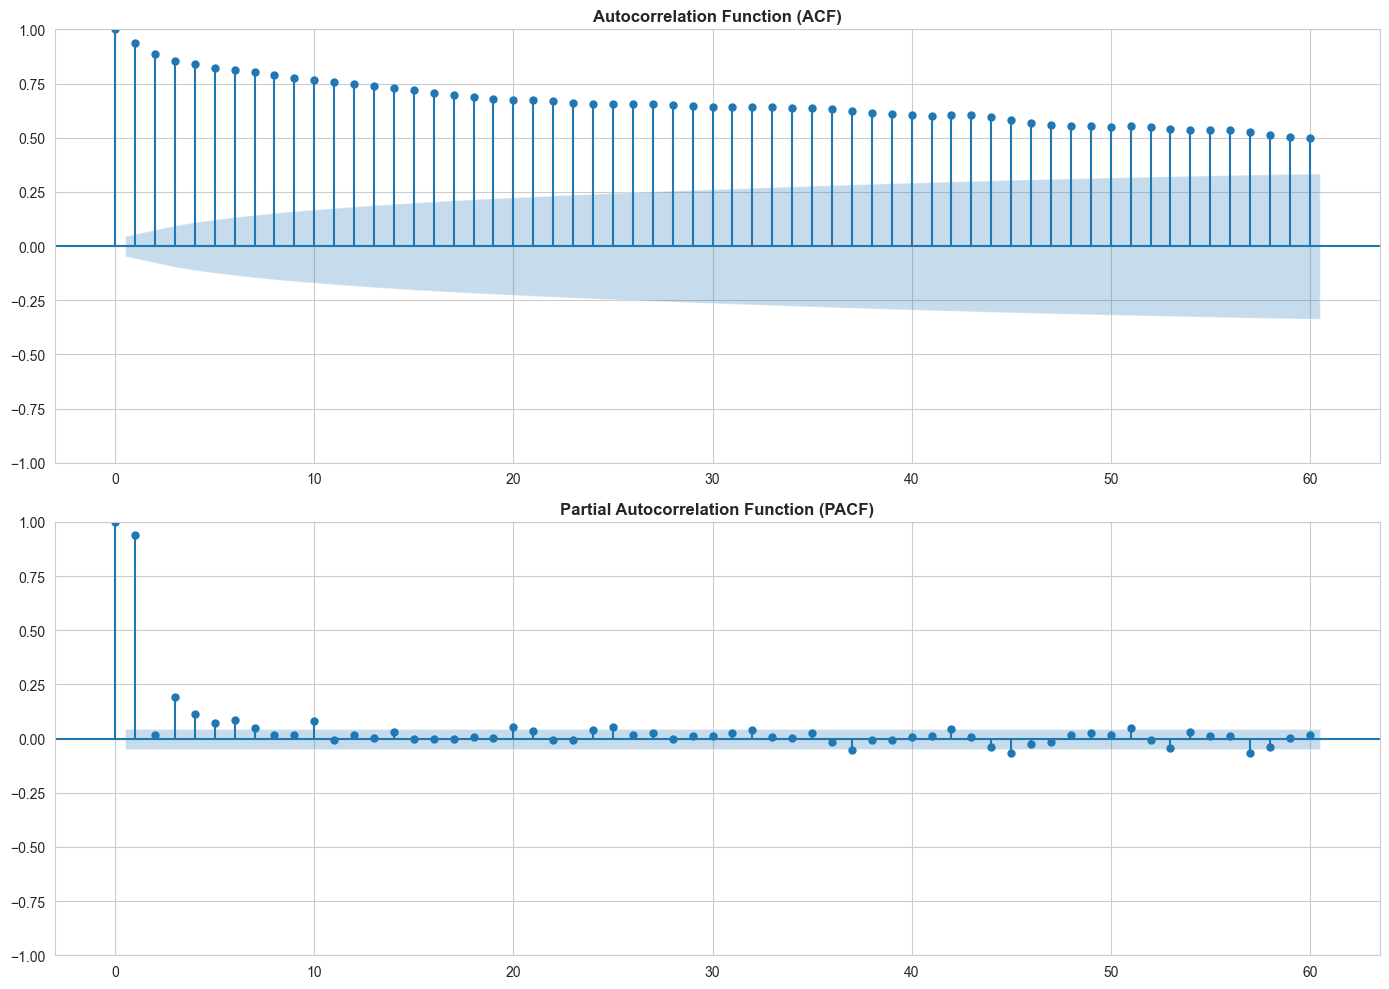

In [12]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(clean_df['y'], lags=60, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')

plot_pacf(clean_df['y'], lags=60, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Train/Val/Test Split

In [13]:
# Create splits
train_df, val_df, test_df = create_train_val_test_split(
    clean_df,
    train_ratio=config['splits']['train_ratio'],
    val_ratio=config['splits']['val_ratio'],
    test_ratio=config['splits']['test_ratio']
)


=== Data Split ===
Train: 1096 records (60.0%) | 2020-01-01 00:00:00 to 2022-12-31 00:00:00
Val:   365 records (20.0%) | 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Test:  366 records (20.0%) | 2024-01-01 00:00:00 to 2024-12-31 00:00:00


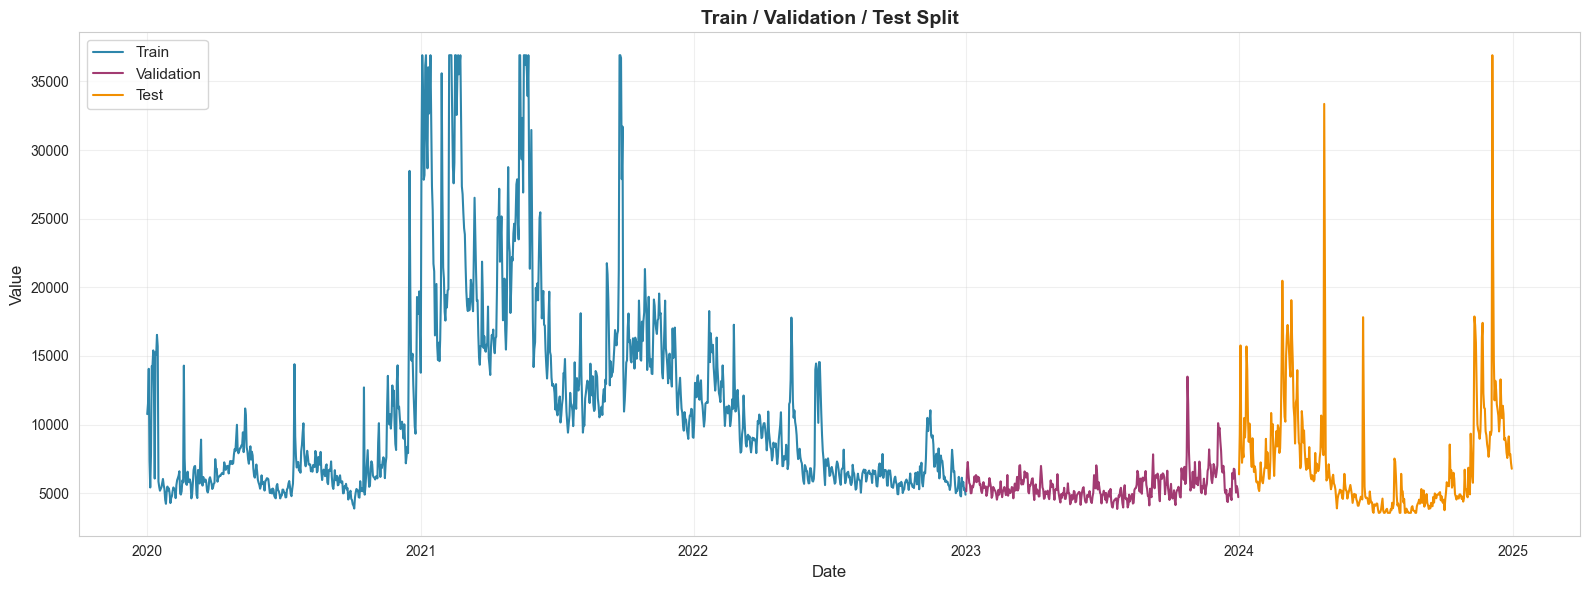

In [14]:
# Visualize splits
plot_train_val_test_split(train_df, val_df, test_df)

## 9. Weekly Patterns

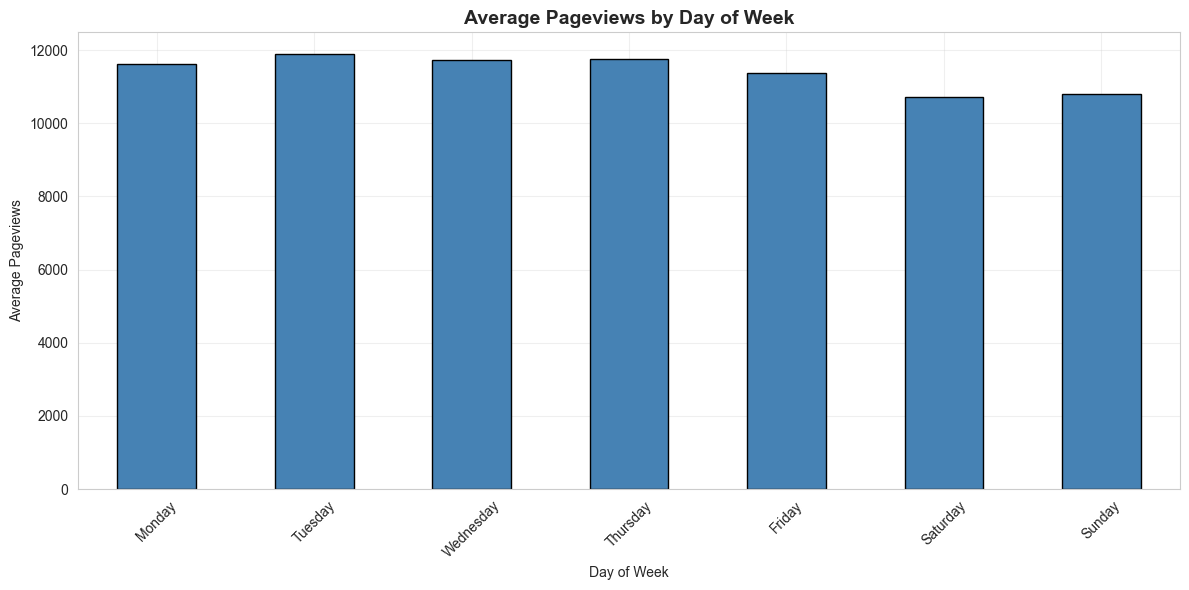

In [15]:
# Add day of week
train_df_copy = train_df.copy()
train_df_copy['day_of_week'] = train_df_copy['ds'].dt.day_name()

# Average by day of week
day_avg = train_df_copy.groupby('day_of_week')['y'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.reindex(day_order)

plt.figure(figsize=(12, 6))
day_avg.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average Pageviews by Day of Week', fontweight='bold', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Average Pageviews')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

Key findings from EDA:
1. Data quality and completeness
2. Presence of weekly seasonality (m=7)
3. Distribution characteristics
4. Train/val/test split validity

The data is now ready for modeling!